In [ ]:
!git clone https://github.com/MLiONS/EarlyExit-Hari.git

fatal: destination path 'EarlyExit-Hari' already exists and is not an empty directory.


For each model (EC-1/ EC-2/ EC-3) + Dataset (Yelp/ IMDb) configuration, the predictions have already been computed and are stored in the "Model_Exit_Predictions" folder. 

In [ ]:
#Select a dataset, a multi-exit model and a cost structure


exit_cnt = 4  #Choices are 4,6 or 8; 4-EC1;6-EC2;8-EC-3
dataset = 'IMDb' #Or 'Yelp' #Or 
cost_struc = "CS-1" #Or "CS-2"


#These are the pre-defined exit configurations for which the models were fine-tuned
if exit_cnt == 4:
  exit_cfg = [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]   #EC-1
elif exit_cnt == 6:
  exit_cfg = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1]   #EC-2
elif exit_cnt == 8:
  exit_cfg = [1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1]   #EC-3

# Loading Exit Predictions

In [ ]:
#Loading the predictions file
import matplotlib.pyplot as plt
import pandas as pd


root_path = '/content/EarlyExit-Hari/Model_Exit_Predictions/Exit_Predictions_'

def get_path(exits, dataset):
  if dataset == 'Yelp':
    return root_path + 'TrainTest_Yelp_' + str(exits) + 'exits.csv'  
  if dataset == 'IMDb':
    return root_path + 'TrainDevTest_IMDb_' + str(exits) + 'exits.csv' 

path = get_path(exit_cnt, dataset)

# In current setting, exits are removed before fine-tuning the model
# Yet another possibility is to remove exits after fine-tuning
# reset_dataset() facilitates this possibility

def reset_dataset(remove_list=[]):
  '''
  Remove exits after fine-tuning procedure
  remove_list List[int]:  Index of exits to be removed (Indexing starts from 0)
  '''
  df = pd.read_csv(path, sep ='\t' )
  num_actual_exits = len(df.columns) - 1
  for num in remove_list:
    del df[str(num)]
  #Exits are renamed from 1 to (#exits)
  df.columns = [str(i) for i in range(1,num_actual_exits - len(remove_list) + 1)] + ['op_labels']
  return df


df = reset_dataset()
num_exits = len(df.columns) - 1
num_samples = len(df)
print('Dataset used for evaluation is ',dataset)
print('Number of exits being considered ',num_exits)
print('The exit configuration is ', exit_cfg)
print('Number of samples in the dataset is ', num_samples)


Dataset used for evaluation is  IMDb
Number of exits being considered  4
The exit configuration is  [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Number of samples in the dataset is  50000


# Joint Exit Prediction Statistics

In [ ]:
#index lists for storing the corresponding index of samples
# "good" and "bad" samples are with regards to algorithm performance
same_preds_index, same_preds_correct_index, triv_preds_index = [], [], []

good_sample_index, bad_sample_index, no_correct_pred_index = [], [], []

for i in range(len(df)):
  # If condition is supposed to take care of all preds are equal case
  # This splits into 2 cases
  # 1: all preds are equal and same as op_label
  # 2: all preds are equal but not same as op_label
  if (df.iloc[i,:num_exits] == df.iloc[i,0]).all():   #are all "preds" same? 
    same_preds_index.append(i)
    if (df.iloc[i,num_exits] == df.iloc[i,0]):    # are all these same preds                                                   
      same_preds_correct_index.append(i)        # same as the op_label?  
    else:                                 #all preds are same but not same as
      triv_preds_index.append(i)          # op_label.
  else:
    corr_pred_found = False
    for j in range(num_exits):                  #find the first exit that matches
      if df.iloc[i,j] == df.iloc[i,num_exits]:  # the op-label.   
        corr_pred_found = True
        if (df.iloc[i,j+1:num_exits] == df.iloc[i,num_exits]).all():                                
          good_sample_index.append(i)    #then if all preds after j 
          break                           #are same as j/ op-label, good sample
        else:             
          bad_sample_index.append(i)      #if not, bad sample
          break
    if not corr_pred_found:
      no_correct_pred_index.append(i)

In [ ]:
#samples where prediction flips after getting it correct in earlier exit
#Strong dominance fails (Bad)
print(f'Number of bad samples is {len(bad_sample_index)}, which is {len(bad_sample_index)*100/num_samples} %', )

#These are the bad samples
df.iloc[bad_sample_index]

Number of bad samples is 7215, which is 14.43 %


,1,2,3,4,op_labels
13,1,0,0,1,1
27,0,1,0,0,0
31,0,1,0,0,1
39,0,1,0,0,1
53,1,1,0,0,1
...,...,...,...,...,...
49985,0,1,0,0,0
49990,0,1,1,1,0
49995,0,1,1,0,0
49996,0,1,1,1,0


In [ ]:
#samples for which all exits predict the same label but it is not equal to op_label (true label)'
#All exit predictions are wrong but strong dominance does not apply/ holds (All Wrg) 
print(f'Number of trivially strong/ "All Wrg" samples is {len(triv_preds_index)}, which is {len(triv_preds_index)*100/num_samples} %', )

#These are the trivial samples
df.iloc[triv_preds_index]

Number of trivially strong/ "All Wrg" samples is 3297, which is 6.594 %


,1,2,3,4,op_labels
3,1,1,1,1,0
11,0,0,0,0,1
22,1,1,1,1,0
29,0,0,0,0,1
40,0,0,0,0,1
...,...,...,...,...,...
49804,1,1,1,1,0
49844,1,1,1,1,0
49846,1,1,1,1,0
49861,1,1,1,1,0


In [ ]:
#samples for which all exits predictions are correct
# All Cor, Strong dominance holds
print(f'Number of "All Cor" samples is {len(same_preds_correct_index)}, which is {len(same_preds_correct_index)*100/num_samples} %', )

#These are the "All Cor" samples
df.iloc[same_preds_correct_index]

Number of "All Cor" samples is 25010, which is 50.02 %


,1,2,3,4,op_labels
0,0,0,0,0,0
1,1,1,1,1,1
4,0,0,0,0,0
5,0,0,0,0,0
9,1,1,1,1,1
...,...,...,...,...,...
49992,0,0,0,0,0
49993,0,0,0,0,0
49994,0,0,0,0,0
49997,0,0,0,0,0


In [ ]:
#samples for which upto a certain exit the predictions are wrong
#but all exits later gets it correct
# Good, Strong dominance holds
print(f'Number of "Good" samples is {len(good_sample_index)}, which is {len(good_sample_index)*100/num_samples} %', )

#These are the "All Cor" samples
df.iloc[good_sample_index]

Number of "Good" samples is 14478, which is 28.956 %


,1,2,3,4,op_labels
2,0,1,1,1,1
6,0,1,1,1,1
7,0,1,1,1,1
8,0,1,1,1,1
17,1,0,0,0,0
...,...,...,...,...,...
49930,1,0,0,0,0
49938,1,0,0,0,0
49952,1,0,0,0,0
49982,1,0,0,0,0


# Ascertaining the optimal exit (to compute regret)

Error Probabilities

In [ ]:
#Error probabilities (1 - accuracy)
error_prob = []
for i in range(num_exits):
  acc = len(df[df[str(i+1)] == df['op_labels']])/ num_samples #to match the column index
  error_prob.append(1 - acc)
error_prob

[0.38766, 0.19299999999999995, 0.17090000000000005, 0.15386]

Cost Structure

In [ ]:
#Here we compute the scaled cost that will be directly
#compared with the error probabilities
import math
cost=[]
#CS-1: Number of attention layers used for computing output/12
if cost_struc == 'CS-1':
  for i in range(len(exit_cfg)):
    if exit_cfg[i]:
      cost.append((i+1)/12)

#CS-2: If Number of attention layers used <= 7, cost is 0.5 else 1
elif cost_struc == 'CS-2':
  for i in range(len(exit_cfg)):
    if exit_cfg(i):
      if i <= 6:
        cost.append(0.5)
      else:
        cost.append(1)

cost

[0.08333333333333333, 0.25, 0.5833333333333334, 1.0]

In [ ]:
#Sum of error probabilities and scaled cost
score= []
for i in range(num_exits):
  val = cost[i] + error_prob[i]
  print(val)
  score.append(val)

opt_score = min(score)   #for computing cumulative regret
print(f'optimal exit is {score.index(opt_score) + 1} and optimal (minimum) score is {opt_score}')

0.4709933333333333
0.44299999999999995
0.7542333333333334
1.1538599999999999
optimal exit is 2 and optimal (minimum) score is 0.44299999999999995


# UEE-UCB Algorithm Implementation

In [ ]:
def update_all(t, selected_action, obs_counter, dis_counter, P_1j):
  '''
  function to update the observation counter, obs_counter and
  disagreement with exit 1 counter, dis_counter
  and disagreement proabilities, P_1j at each round based on the selected action
  '''
  #preds_matrix contains the loaded model predictions
  obs_preds = preds_matrix[t, :selected_action]
  for i in range(selected_action):
    obs_counter[i] += 1
    dis_counter[i] += 1 if obs_preds[i] != obs_preds[0] else 0
    P_1j[i] = dis_counter[i]/obs_counter[i]


def find_action(t, P_1j, obs_counter, alpha):
  '''
  Given current values of disagreement prob and observation counter
  function/ algorithm selects an action
  '''
  exit_scores = []
  for j in range(num_exits):
    score = P_1j[j] + cost[0] - cost[j] + ((alpha*math.log(t+1))/obs_counter[j])**0.5
    exit_scores.append(score)
  return exit_scores.index(max(exit_scores)) + 1


In [ ]:
import numpy as np
from collections import Counter

def run_single_trial():
  '''
  Runs a single trial of the experiment
  '''
  global uee_cost_tot, uee_acc_tot, rand_acc_tot,  rand_cost_tot
  #Initialisation
  alpha = 1

  obs_counter = [0 for _ in range(num_exits)]   #Number of times prediction of a certain  exit is observed
  dis_counter = [0 for _ in range(num_exits)]   #Total number of times an exit disagrees with the first exit
  P_1j = [0 for _ in range(num_exits)]          #Estimates of diagreement probabilities
  action_hist = []                              # Store selected exits across time/ rounds
  rand_act_hist = []                  #Store randomly selected actions                
  c_reg, c_reg_rand = 0, 0            #cumulative regret for t=0
  c_reg_hist = []                     #Stores cumulative regret after each round for UEE-UCB
  c_reg_rand_hist = []                #Stores cum regret for random baseline algorithm      
  c_reg_hist.append(c_reg)
  c_reg_rand_hist.append(c_reg_rand)
  cost_act = 0                        #To store the accumulated cost of UEE-UCB
  cost_rand = 0                       #To store acc. cost of random baseline


  #ALGORITHM

  for t in range(0, len(df)):
    selected_action = num_exits if t==0 else find_action(t, P_1j, obs_counter, alpha)
    #print(selected_action)
    action_hist.append(selected_action)
    update_all(t, selected_action, obs_counter, dis_counter, P_1j)

    # Storing regret values, costs for UEE-UCB, random baseline 
    c_reg += score[selected_action-1] - opt_score
    cost_act += cost[selected_action-1]
    c_reg_hist.append(c_reg)
  
    rand_act = np.random.choice(list(range(num_exits)))
    cost_rand += cost[rand_act]
    rand_act_hist.append(rand_act)
    c_reg_rand += score[rand_act] - opt_score
    c_reg_rand_hist.append(c_reg_rand) 

  #No: of times each exit was selected by UEE-UCB 
  print(dict(Counter(action_hist)))

  #Storing the regret values for UEE-UCB as well as "random" baseline
  c_reg_hist_stack.append(c_reg_hist)
  c_reg_rand_hist_stack.append(c_reg_rand_hist)
  action_hist_stack.append(action_hist)   #Storing action histories for each trial

  # To compare the cost-accuracy trade-off 
  corr_pred, corr_pred_rand = 0, 0
  for t in range(len(df)):
    if df_res.iloc[t, action_hist[t]-1] == df_res.iloc[t, num_exits]:
      corr_pred += 1
    if df_res.iloc[t, rand_act_hist[t]] == df_res.iloc[t, num_exits]:
      corr_pred_rand += 1      

  #Computing average accuracy and per sample averaged cost for UEE-UCB and
  #random baseline
  uee_acc_tot += corr_pred/ num_samples
  rand_acc_tot += corr_pred_rand/ num_samples

  rand_cost_tot +=cost_rand
  uee_cost_tot +=cost_act

  return action_hist

In [ ]:
uee_cost_tot, uee_acc_tot, rand_acc_tot, rand_cost_tot = 0, 0 , 0 ,0

#For storing the regret values in each trial (to compute confidence intervals)
c_reg_hist_stack = []
c_reg_rand_hist_stack = []
action_hist_stack = []

num_trials = 20
for i in range(num_trials):
  print('#Trial', i)
  df = reset_dataset()
  # To change the share of bad samples in the dataset
  #df = df.iloc[same_preds_correct_index + good_sample_index + triv_preds_index ]
  df = df.sample(frac=1, random_state=i)  #Shuffle dataset
  df_res = df.copy(deep = True)
  del df['op_labels']
  preds_matrix = df.to_numpy(dtype=int)
  run_single_trial()

#Trial 0
{4: 17, 2: 49900, 3: 83}
#Trial 1
{4: 17, 2: 49946, 3: 37}
#Trial 2
{4: 39, 1: 3, 2: 49805, 3: 153}
#Trial 3
{4: 11, 2: 49906, 3: 83}
#Trial 4
{4: 35, 1: 2, 2: 49916, 3: 47}
#Trial 5
{4: 29, 2: 49904, 3: 67}
#Trial 6
{4: 13, 1: 7, 2: 49898, 3: 82}
#Trial 7
{4: 18, 1: 3, 2: 49901, 3: 78}
#Trial 8
{4: 18, 2: 49900, 3: 82}
#Trial 9
{4: 17, 1: 1, 2: 49872, 3: 110}
#Trial 10
{4: 26, 2: 49882, 3: 92}
#Trial 11
{4: 28, 2: 49879, 3: 93}
#Trial 12
{4: 20, 2: 49925, 3: 54, 1: 1}
#Trial 13
{4: 17, 2: 49959, 3: 24}
#Trial 14
{4: 18, 1: 1, 2: 49873, 3: 108}
#Trial 15
{4: 18, 3: 182, 1: 5, 2: 49795}
#Trial 16
{4: 20, 1: 7, 2: 49927, 3: 46}
#Trial 17
{4: 18, 1: 2, 2: 49887, 3: 93}
#Trial 18
{4: 13, 2: 49916, 3: 70, 1: 1}
#Trial 19
{4: 9, 1: 1, 2: 49919, 3: 71}


In [ ]:
print('###')
print('Average accuracy for UEE-UCB algorithm', uee_acc_tot/num_trials)
print('Averaged Per-sample cost for UEE-UCB algorithm',uee_cost_tot/num_trials/num_samples)
print('###')
print('Average accuracy for random algorithm', rand_acc_tot/num_trials)
print('Averaged Per-sample cost for random algorithm',rand_cost_tot/num_trials/num_samples)
print('###')


###
Average accuracy for UEE-UCB algorithm 0.8070579999999999
Averaged Per-sample cost for UEE-UCB algorithm 0.2508467500000001
###
Average accuracy for random algorithm 0.773935
Averaged Per-sample cost for random algorithm 0.479001416666558
###


In [ ]:
import scipy.stats as st

#2-D arrays with #num_trials x num_samples cumulative regret values
reg_arr = np.asarray(c_reg_hist_stack)
reg_arr_ran = np.asarray(c_reg_rand_hist_stack)

#to store the 95% confidence interval (upper and lower boundary)
upper, upper_ran = [], []
lower, lower_ran = [], []


# create 95% confidence interval (assuming t-distribution)
for i in range(2, num_samples):
  intrval = st.t.interval(alpha=0.95, df=len(reg_arr[:,i])-1,
              loc=np.mean(reg_arr[:,i]),
              scale=st.sem(reg_arr[:,i]))
  lower.append(intrval[0])
  upper.append(intrval[1])

  intrval = st.t.interval(alpha=0.95, df=len(reg_arr_ran[:,i])-1,
              loc=np.mean(reg_arr_ran[:,i]),
              scale=st.sem(reg_arr_ran[:,i]))
  lower_ran.append(intrval[0])
  upper_ran.append(intrval[1])

#Computing cumulative regret for "always last exit" baseline
c_reg_last = 0
c_reg_last_hist = []
c_reg_last_hist.append(c_reg_last)

for _ in range(num_samples):
  c_reg_last += score[num_exits-1] - opt_score
  c_reg_last_hist.append(c_reg_last)

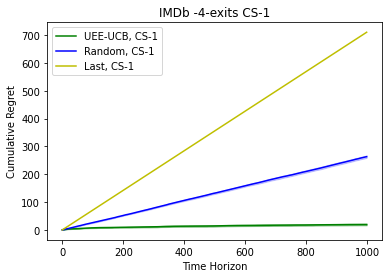

In [ ]:
num =1000
#plt.ylim(0,800)
plt.plot(reg_arr.mean(axis=0)[:num] , 'g', label='UEE-UCB, '+ cost_struc)
plt.fill_between(list(range(2,num)), lower[:num-2], upper[:num-2], color='green', alpha=0.4)
plt.plot(reg_arr_ran.mean(axis=0)[:num] , 'b', label='Random, '+ cost_struc)
plt.fill_between(list(range(2,num)), lower_ran[:num-2], upper_ran[:num-2], color='b', alpha=0.2)
plt.plot(c_reg_last_hist[:num] , 'y', label='Last, '+ cost_struc)
plt.title(dataset +', '+ str(exit_cnt)+'-exits, ' + cost_struc)
plt.xlabel('Time Horizon')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.savefig('c_reg_plot_4_exit_IMDb_cs1.pdf')

plt.show()

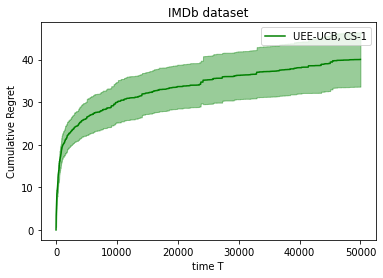

In [ ]:
num = 50000
plt.plot(reg_arr.mean(axis=0)[:num] , 'g', label='UEE-UCB, ' + cost_struc)
plt.fill_between(list(range(2,num)), lower[:num-2], upper[:num-2], color='green', alpha=0.4)

plt.title(dataset+' dataset')
plt.xlabel('time T')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.savefig('c_reg_plot.png')
plt.show()

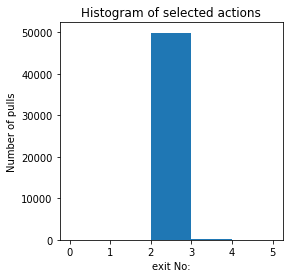

In [ ]:
fig, ax = plt.subplots(figsize =(4, 4))
ax.hist(action_hist_stack[0], bins = list(range(num_exits+2)))
plt.title('Histogram of selected actions')
plt.xlabel('exit No:')
plt.ylabel('Number of pulls')

# Show plot
plt.savefig('Action_histogram.png')

plt.show()